In [1]:
import os

In [2]:
!pwd

/home/jovyan/notebooks/analysis/benchmarking_against_NAS


In [3]:
import sys
sys.path.append('/home/jovyan/')

In [4]:
from experiments.reporting.report_repository import ReportRepository
from experiments.slack_client import SlackNotifier
from neat.neat_logger import get_neat_logger
from neat.population_engine import EvolutionEngine
from neat.reporting.reports_pyneat import EvolutionReport
from neat.utils import timeit
import math
import random
from itertools import count
import numpy as np

from experiments.logger import logger
from experiments.slack_client import Notifier
from experiments.object_repository.object_repository import ObjectRepository
from experiments.reporting.report_repository import ReportPathFactory
from neat.configuration import get_configuration
from neat.evaluation.evaluation_engine import EvaluationStochasticEngine
from neat.evolution_operators.crossover import Crossover
from neat.evolution_operators.mutation import Mutation
from neat.genome import Genome
from neat.reporting.reports_pyneat import EvolutionReport
from neat.species import SpeciationEngine
from neat.stagnation import Stagnation
from neat.population_engine import PopulationEngine
from neat.utils import timeit
import neat
import tests
from config_files.configuration_utils import create_configuration
from neat.configuration import get_configuration, set_configuration
from neat.evaluation.evaluation_engine import get_dataset
from neat.evaluation.evaluate_simple import evaluate_genome, calculate_prediction_distribution
from neat.genome import Genome
from neat.evolution_operators.backprop_mutation import BackPropMutation
import os
from neat.loss.vi_loss import get_loss
import torch
import pandas as pd

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from neat.analysis.experiment_data import ExperimentData
from neat.analysis.uncertainty.predictive_distribution import PredictionDistributionEstimator
from neat.analysis.plotting.plot_losses import plot_loss_distribution
from neat.analysis.plotting.plot_classification_metrics import plot_metrics_by_quantile_several_executions
from neat.analysis.experiment_predictive_distributions import ExecutionsPredictionDistributions

In [7]:
LOGS_PATH = f'{os.getcwd()}/'
logger = get_neat_logger(path=LOGS_PATH)

In [8]:
PROJECT = 'neuro-evolution'
ALGORITHM_VERSION = 'bayes-neat'
DATASET = 'titanic'

# correlation_ids = [f'neat_ft_1_{DATASET}', f'bayesian_neat_ft_1_{DATASET}']
correlation_ids = [f'bayesian_neat_ft_1_{DATASET}'] 

In [9]:
# from IPython.core.debugger import set_trace
# set_trace()
experiment_data_ne = ExperimentData(correlation_ids=correlation_ids, dataset_name=DATASET, n_samples=1000,
                                 project=PROJECT, algorithm_version=ALGORITHM_VERSION,
                                keep_top=1.0)\
                    .process_data()
data_ne = experiment_data_ne.get_experiment_data()
data_ne = data_ne.loc[data_ne['noise'] == 0.0]
data_ne['version'] = 'Bayesian Neuro-Evolution'
data_ne.head()

###########
CORRELATION ID: bayesian_neat_ft_1_titanic
Fitness of best individual: -0.5604114532470703
Train percentage: 0.75
Random state: 39
Sum Train: -3.873417854309082
Training: 535. Testing: 179
Fitness of best individual: -0.4753590226173401
Train percentage: 0.75
Random state: 61
Sum Train: -17.977418899536133
Training: 535. Testing: 179
Fitness of best individual: -0.41052478551864624
Train percentage: 0.75
Random state: 8
Sum Train: -4.4586405754089355
Training: 535. Testing: 179
Fitness of best individual: -0.44371673464775085
Train percentage: 0.75
Random state: 62
Sum Train: -25.549943923950195
Training: 535. Testing: 179
Fitness of best individual: -0.5703664422035217
Train percentage: 0.75
Random state: 2
Sum Train: 9.48783016204834
Training: 535. Testing: 179
Fitness of best individual: -0.44641977548599243
Train percentage: 0.75
Random state: 38
Sum Train: -28.526988983154297
Training: 535. Testing: 179
Fitness of best individual: -0.5853896737098694
Train percentage: 

/home/jovyan/neat/analysis/experiment_data.py:186: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  executions_per_experiment = experiment_data.groupby(filtering_group)['execution_id'].nunique().reset_index()\
/home/jovyan/neat/analysis/experiment_data.py:193: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  for filtering_group_values, experiment_data_per_correlation_id in experiment_data.groupby(filtering_group):
/home/jovyan/neat/analysis/experiment_data.py:199: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  experiment_data_per_correlation_id.sort_v

,correlation_id,execution_id,train_percentage,noise,is_bayesian,beta,loss_training,loss_testing,duration,end_condition,n_parameters,n_nodes,n_connections,mean_genome_std,accuracy,f1,version
0,bayesian_neat_ft_1_titanic,ddcc7657-3006-48b8-967c-e7548a5b0050,0.75,0.0,True,0.000001,0.390065,0.473425,0:08:25.153793,normal,94,14,33,0.600836,80.625140,0.803680,Bayesian Neuro-Evolution
1,bayesian_neat_ft_1_titanic,3631f0f0-86ac-4664-9b75-3261d7e6e44f,0.75,0.0,True,0.000001,0.410525,0.443508,0:06:51.503388,normal,70,10,25,0.434053,80.714525,0.804720,Bayesian Neuro-Evolution
2,bayesian_neat_ft_1_titanic,f8580393-e5ce-49b4-a32b-ea582eb015c7,0.75,0.0,True,0.000001,0.425901,0.442144,0:09:52.070694,normal,62,9,22,0.444486,79.565363,0.788632,Bayesian Neuro-Evolution
3,bayesian_neat_ft_1_titanic,57204de5-900d-4245-934d-92c14e16e117,0.75,0.0,True,0.000001,0.443717,0.446788,0:09:31.883414,normal,68,10,24,0.661800,82.001676,0.815668,Bayesian Neuro-Evolution
4,bayesian_neat_ft_1_titanic,66f07772-235b-4b66-b5c8-3f9398f96d30,0.75,0.0,True,0.000001,0.446420,0.436633,0:07:09.387048,normal,50,7,18,0.296200,81.567598,0.813672,Bayesian Neuro-Evolution


In [10]:
data_ne

,correlation_id,execution_id,train_percentage,noise,is_bayesian,beta,loss_training,loss_testing,duration,end_condition,n_parameters,n_nodes,n_connections,mean_genome_std,accuracy,f1,version
0,bayesian_neat_ft_1_titanic,ddcc7657-3006-48b8-967c-e7548a5b0050,0.75,0.0,True,0.000001,0.390065,0.473425,0:08:25.153793,normal,94,14,33,0.600836,80.625140,0.803680,Bayesian Neuro-Evolution
1,bayesian_neat_ft_1_titanic,3631f0f0-86ac-4664-9b75-3261d7e6e44f,0.75,0.0,True,0.000001,0.410525,0.443508,0:06:51.503388,normal,70,10,25,0.434053,80.714525,0.804720,Bayesian Neuro-Evolution
2,bayesian_neat_ft_1_titanic,f8580393-e5ce-49b4-a32b-ea582eb015c7,0.75,0.0,True,0.000001,0.425901,0.442144,0:09:52.070694,normal,62,9,22,0.444486,79.565363,0.788632,Bayesian Neuro-Evolution
3,bayesian_neat_ft_1_titanic,57204de5-900d-4245-934d-92c14e16e117,0.75,0.0,True,0.000001,0.443717,0.446788,0:09:31.883414,normal,68,10,24,0.661800,82.001676,0.815668,Bayesian Neuro-Evolution
4,bayesian_neat_ft_1_titanic,66f07772-235b-4b66-b5c8-3f9398f96d30,0.75,0.0,True,0.000001,0.446420,0.436633,0:07:09.387048,normal,50,7,18,0.296200,81.567598,0.813672,Bayesian Neuro-Evolution


# Get NAS

In [11]:
def _calculate_network_size(n_input, n_output, n_hidden_layers, n_neurons_per_layer):
    n_nodes = n_output + n_neurons_per_layer*n_hidden_layers
    n_connections = n_input*n_neurons_per_layer 
    for i in range(n_hidden_layers-1):
        n_connections += n_neurons_per_layer**2
    n_connections += n_neurons_per_layer * n_output
    return n_nodes, n_connections


def _process_nas_execution(report):
    correlation_id = report.correlation_id
    execution_id = report.execution_id
    train_percentage = report.configuration['train_percentage']
    noise = report.configuration['noise']
    beta = report.configuration['beta']
    n_input = report.configuration['n_input']
    n_output = report.configuration['n_output']
    end_condition = report.end_condition
    duration = report.duration
    accuracy = report.metrics['accuracy']
    f1 = report.metrics['f1']
    
    n_hidden_layers = report.best_network_params['n_hidden_layers']
    n_neurons_per_layer = report.best_network_params['n_neurons_per_layer']
    
    
    n_nodes, n_connections = _calculate_network_size(n_input, n_output, n_hidden_layers, n_neurons_per_layer)
    
    n_parameters = (n_nodes + n_connections) * 2
    df_report = pd.DataFrame({'correlation_id': correlation_id,
                                  'execution_id': execution_id,
                                  'train_percentage': train_percentage,
                                  'noise': noise,
                                  'is_bayesian': True,
                                  'beta': beta,
                                  'duration': duration,
                                  'end_condition': end_condition,
                                  'n_parameters': n_parameters,
                                  'n_nodes': n_nodes,
                                  'n_connections': n_connections,
                                  'f1': f1,
                                  'accuracy': accuracy,
                                  }, index=[0])
    
    return df_report


def process_reports_nas(reports):
    chunks = []
    for execution_id, report in reports.items():
        chunks.append(_process_nas_execution(report))
    
    return pd.concat(chunks, sort=False)

In [12]:
project_nas='nas'
algorithm_version_nas ='nas'
correlation_ids_nas = ['nas_v1']

In [13]:
experiment_data_ne = ExperimentData(correlation_ids=correlation_ids_nas, dataset_name=DATASET, n_samples=1000,
                                    project=project_nas, algorithm_version=algorithm_version_nas,
                                    keep_top=1.0)
reports = experiment_data_ne.get_reports()
reports

###########
CORRELATION ID: nas_v1


{'04f27908-3876-4e17-be8f-c41f60c86819': <experiments.reporting.report.BaseReport at 0x7fe1dea68610>,
 '14c0ea81-4a32-4960-b537-8cd00c96eb7b': <experiments.reporting.report.BaseReport at 0x7fe1deb77b10>,
 '27ec7e9c-82ba-4781-bc63-ab31f70f8ba5': <experiments.reporting.report.BaseReport at 0x7fe1decd1510>,
 '2b9c2f7f-4d8f-4b78-b003-9e6e12f3525c': <experiments.reporting.report.BaseReport at 0x7fe1decbc490>,
 '2fa35621-7f6a-4e09-b328-2b3b3885972c': <experiments.reporting.report.BaseReport at 0x7fe1deb79610>,
 '329bdf68-7c82-4583-93f5-285b60c61d9a': <experiments.reporting.report.BaseReport at 0x7fe1df374a90>,
 '3fa3ca8f-69b7-457b-9cb6-65a0d46a8b4b': <experiments.reporting.report.BaseReport at 0x7fe1def8c390>,
 '41475bed-8473-4d7a-8560-3fee220d63ed': <experiments.reporting.report.BaseReport at 0x7fe1df240590>,
 '5afd2cb2-3115-4316-833e-aea752f545f5': <experiments.reporting.report.BaseReport at 0x7fe1def8ce10>,
 '5ba6bfc0-6acf-4c02-97d1-04690cb449f9': <experiments.reporting.report.BaseReport 

In [14]:
data_nas = process_reports_nas(reports)
data_nas['version'] = 'Grid Search BackProp'
data_nas

,correlation_id,execution_id,train_percentage,noise,is_bayesian,beta,duration,end_condition,n_parameters,n_nodes,n_connections,f1,accuracy,version
0,nas_v1,04f27908-3876-4e17-be8f-c41f60c86819,0.75,0.0,True,0.0,0:00:00.000015,normal,1096,44,504,0.765555,77.128492,Grid Search BackProp
0,nas_v1,14c0ea81-4a32-4960-b537-8cd00c96eb7b,0.75,0.0,True,0.0,0:00:00.000011,normal,754,32,345,0.770212,77.251397,Grid Search BackProp
0,nas_v1,27ec7e9c-82ba-4781-bc63-ab31f70f8ba5,0.75,0.0,True,0.0,0:00:00.000012,normal,292,18,128,0.794156,80.117318,Grid Search BackProp
0,nas_v1,2b9c2f7f-4d8f-4b78-b003-9e6e12f3525c,0.75,0.0,True,0.0,0:00:00.000014,normal,346,21,152,0.780205,78.106145,Grid Search BackProp
0,nas_v1,2fa35621-7f6a-4e09-b328-2b3b3885972c,0.75,0.0,True,0.0,0:00:00.000012,normal,116,10,48,0.774076,77.530726,Grid Search BackProp
0,nas_v1,329bdf68-7c82-4583-93f5-285b60c61d9a,0.75,0.0,True,0.0,0:00:00.000012,normal,836,34,384,0.782830,78.536313,Grid Search BackProp
0,nas_v1,3fa3ca8f-69b7-457b-9cb6-65a0d46a8b4b,0.75,0.0,True,0.0,0:00:00.000012,normal,220,14,96,0.801685,80.430168,Grid Search BackProp
0,nas_v1,41475bed-8473-4d7a-8560-3fee220d63ed,0.75,0.0,True,0.0,0:00:00.000016,normal,354,23,154,0.747966,75.396648,Grid Search BackProp
0,nas_v1,5afd2cb2-3115-4316-833e-aea752f545f5,0.75,0.0,True,0.0,0:00:00.000011,normal,166,11,72,0.792455,79.480447,Grid Search BackProp
0,nas_v1,5ba6bfc0-6acf-4c02-97d1-04690cb449f9,0.75,0.0,True,0.0,0:00:00.000012,normal,602,28,273,0.779863,78.229050,Grid Search BackProp


In [15]:
data = pd.concat([data_ne, data_nas])
data.dropna(axis=1, inplace=True)
data.drop(columns=['correlation_id', 'execution_id', ], inplace=True)
data

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,accuracy,beta,duration,end_condition,f1,is_bayesian,n_connections,n_nodes,n_parameters,noise,train_percentage,version
0,80.625140,0.000001,0:08:25.153793,normal,0.803680,True,33,14,94,0.0,0.75,Bayesian Neuro-Evolution
1,80.714525,0.000001,0:06:51.503388,normal,0.804720,True,25,10,70,0.0,0.75,Bayesian Neuro-Evolution
2,79.565363,0.000001,0:09:52.070694,normal,0.788632,True,22,9,62,0.0,0.75,Bayesian Neuro-Evolution
3,82.001676,0.000001,0:09:31.883414,normal,0.815668,True,24,10,68,0.0,0.75,Bayesian Neuro-Evolution
4,81.567598,0.000001,0:07:09.387048,normal,0.813672,True,18,7,50,0.0,0.75,Bayesian Neuro-Evolution
0,77.128492,0.000000,0:00:00.000015,normal,0.765555,True,504,44,1096,0.0,0.75,Grid Search BackProp
0,77.251397,0.000000,0:00:00.000011,normal,0.770212,True,345,32,754,0.0,0.75,Grid Search BackProp
0,80.117318,0.000000,0:00:00.000012,normal,0.794156,True,128,18,292,0.0,0.75,Grid Search BackProp
0,78.106145,0.000000,0:00:00.000014,normal,0.780205,True,152,21,346,0.0,0.75,Grid Search BackProp
0,77.530726,0.000000,0:00:00.000012,normal,0.774076,True,48,10,116,0.0,0.75,Grid Search BackProp


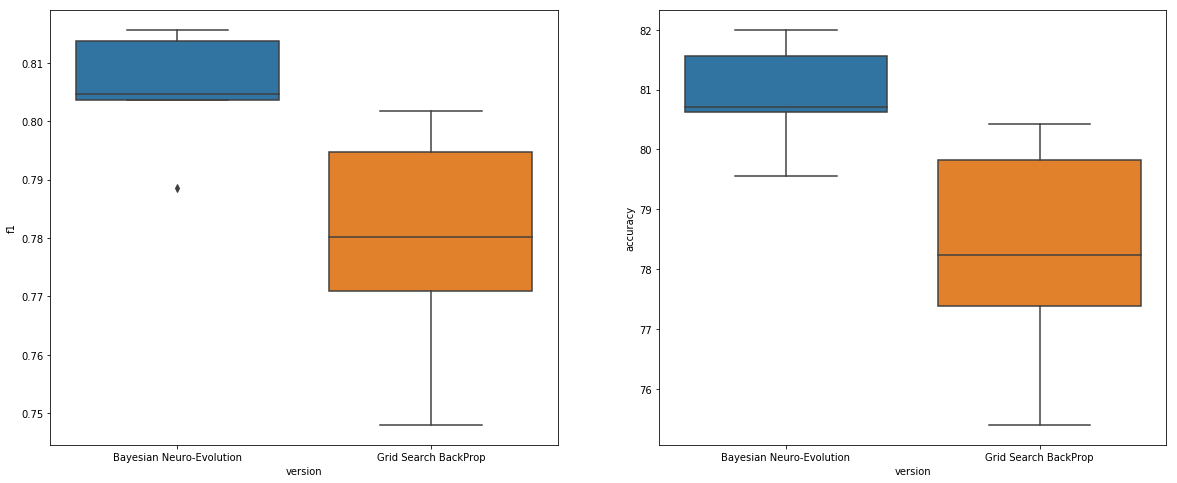

In [16]:
# sns.boxplot(data=data, y='accuracy', x='version')

_, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 8))
sns.boxplot(data=data, x='version', y='f1', ax=ax1)
sns.boxplot(data=data, x='version', y='accuracy', ax=ax2)
# ax1.set_ylim([0, 1])
# ax2.set_ylim([0, 100])

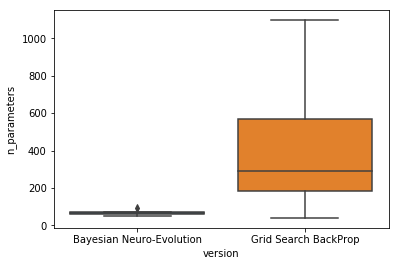

In [17]:
sns.boxplot(data=data, y='n_parameters', x='version')

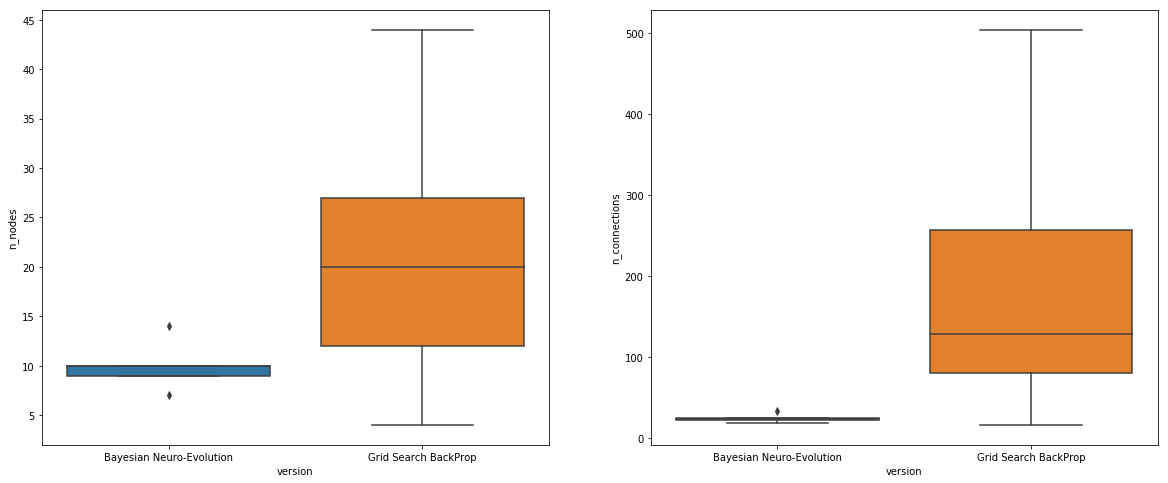

In [18]:
_, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 8))
sns.boxplot(data=data, x='version', y='n_nodes', ax=ax1)
sns.boxplot(data=data, x='version', y='n_connections', ax=ax2)

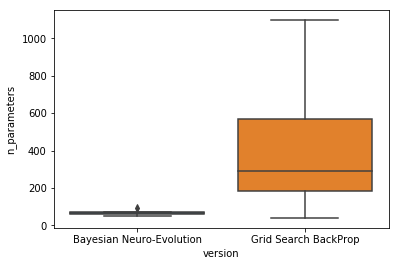

In [19]:
sns.boxplot(data=data, y='n_parameters', x='version')